# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/MyDrive/UBS-Auto_Server_Audit /Detectron'

/content/drive/.shortcut-targets-by-id/1xuo4FVROJBpOYQfz9QcDshp5kPAvpxB1/UBS-Auto_Server_Audit /Detectron


# **Install Required Packages**

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.7 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
# install detectron2:

# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

!pip install -U 'git+https://github.com/facebookresearch/detectron2.git@543fd075e146261c2e2b0770c9b537314bdae572'
!pip install -U 'git+https://github.com/facebookresearch/fvcore@4525b814c8bb0f70510e37e68247c958010eb285'


# **Import Detectron Packages**

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import torch, torchvision
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [ ]:

def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');

# **Custom method for reading Bbox**

In [ ]:
import cv2
import os
class_name = ['Printer','Computer monitor','Computer keyboard']
def extract_boxes(img_path,ann_path):
    boxes = list()
    with open(ann_path) as f:
        data_list = f.read().split('\n')
        data_list = [d.split() for d in data_list if d]
        for data in data_list:
            name = ' '.join(data[:-4])
            xmin = int(float(data[-4]))
            ymin = int(float(data[-3]))
            xmax = int(float(data[-2]))
            ymax = int(float(data[-1]))
            coors = [xmin, ymin, xmax, ymax, name]
            if name in class_name:
                boxes.append(coors)
        # directory path
        img = cv2.imread(img_path)
        height, width, _ = img.shape
        return boxes, width, height

def get_balloon_dicts(images_dir,annotations_dir):
    dataset_dicts = []
    for filename in os.listdir(images_dir):
      idx = 0
      if filename[-4:] == '.jpg':
        image_id = filename[:-4]
        img_path = images_dir + filename
        ann_path = annotations_dir + image_id + '.txt'
        boxes, width, height = extract_boxes(img_path,ann_path)
        record = {}
        record["file_name"] = img_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []
        # print(boxes)
        for bndbox in boxes:
          # print('=================================================')
          bbox = []
          #x
          bbox.append(bndbox[0])
          #y
          bbox.append(bndbox[1])
          #w
          bbox.append(bndbox[2] - bndbox[0])
          #h
          bbox.append(bndbox[3] - bndbox[1])
          #bbox[] is x,y,w,h
          seg = []
          #left_top
          seg.append(bbox[0])
          seg.append(bbox[1])
          #left_bottom
          seg.append(bbox[0])
          seg.append(bbox[1] + bbox[3])
          #right_bottom
          seg.append(bbox[0] + bbox[2])
          seg.append(bbox[1] + bbox[3])
          #right_top
          seg.append(bbox[0] + bbox[2])
          seg.append(bbox[1])

          obj = {
                  "bbox": bbox,
                  "bbox_mode": BoxMode.XYWH_ABS,
                  "segmentation": [seg],
                  "category_id": class_name.index(bndbox[-1]), #c[-1]
              }
          objs.append(obj)
        record["annotations"] = objs
        
        idx = idx + 1
        dataset_dicts.append(record)
    return dataset_dicts






# **Directory Path**

In [ ]:
### train
train_images_dir = '/content/drive/MyDrive/mask_rcnn_data/pmk images/printer_img_train/'
train_annotations_dir = '/content/drive/MyDrive/mask_rcnn_data/pmk images/printer_annot_train/'
###val
val_images_dir = '/content/drive/MyDrive/mask_rcnn_data/pmk images/printer_img_test/'
val_annotations_dir = '/content/drive/MyDrive/mask_rcnn_data/pmk images/printer_annot_test/'


# **Neptune integration**
Step 1: Initialize a Neptune Run

In [ ]:
!pip install neptune-client

import neptune.new as neptune

run = neptune.init(
    project="bhallasaab804/detectron",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJmYzgwODFlMy00NDRlLTQxZGEtYmM0Yy1iODVhMWNlMzBmMWIifQ==",
    tags=['detectron with mask-rcnn','cutmix augumentation'],
)  

# **Register dataset**

In [ ]:
DatasetCatalog.register('train', lambda: get_balloon_dicts(train_images_dir,train_annotations_dir))
MetadataCatalog.get('train').thing_classes = class_name

DatasetCatalog.register('val', lambda: get_balloon_dicts(val_images_dir,val_annotations_dir))
MetadataCatalog.get('val').thing_classes = class_name



balloon_metadata = MetadataCatalog.get("train")

# **Visualize dataset**

In [ ]:
# To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:

import matplotlib.pyplot as plt
dataset_dicts = get_balloon_dicts(val_images_dir,val_annotations_dir)

for d in dataset_dicts:
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

# **Custom Code for evaluator**

In [ ]:
from detectron2.engine import HookBase
from detectron2.data import build_detection_train_loader
import detectron2.utils.comm as comm




class ValidationLoss(HookBase):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg.clone()
        self.cfg.DATASETS.TRAIN = cfg.DATASETS.VAL
        self._loader = iter(build_detection_train_loader(self.cfg))
        
    def after_step(self):
        data = next(self._loader)
        with torch.no_grad():
            loss_dict = self.trainer.model(data)
            
            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = {"val_" + k: v.item() for k, v in 
                                 comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            if comm.is_main_process():
                self.trainer.storage.put_scalars(total_val_loss=losses_reduced, 
                                                 **loss_dict_reduced)
                



# **Train Detectron**

In [ ]:
import torch
cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.VAL = ("val",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 100 #
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.OUTPUT_DIR = '/content/drive/MyDrive/UBS-Auto_Server_Audit /Detectron/check_output_mask-rcnn'
cfg.TEST.EVAL_PERIOD = 100

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)



# print("-----------------------")
# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
val_loss = ValidationLoss(cfg)  
trainer.register_hooks([val_loss])
# swap the order of PeriodicWriter and ValidationLoss
trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]
trainer.resume_or_load(resume=False)
trainer.train()

[01/10 04:11:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[01/10 04:11:50 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/boxes.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = torch.as_tensor(tensor, dtype=torch.float32, device=device)
/usr/local/lib/python3.7/dist-packages/detectron2/structures/boxes.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = torch.as_tensor(tensor, dtype=torch.float32, device=device)
/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:101: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It curre

[01/10 04:11:57 d2.utils.events]:  eta: 0:00:17  iter: 19  total_loss: 2.077  loss_cls: 1.296  loss_box_reg: 0.0922  loss_mask: 0.6927  loss_rpn_cls: 0.01057  loss_rpn_loc: 0.005327  total_val_loss: 2.196  val_loss_cls: 1.321  val_loss_box_reg: 0.1137  val_loss_mask: 0.691  val_loss_rpn_cls: 0.01102  val_loss_rpn_loc: 0.004711  time: 0.2175  data_time: 0.0123  lr: 4.7703e-05  max_mem: 2969M
[01/10 04:12:03 d2.utils.events]:  eta: 0:00:12  iter: 39  total_loss: 1.261  loss_cls: 0.4788  loss_box_reg: 0.1041  loss_mask: 0.5978  loss_rpn_cls: 0.006344  loss_rpn_loc: 0.005659  total_val_loss: 1.289  val_loss_cls: 0.4937  val_loss_box_reg: 0.1031  val_loss_mask: 0.5707  val_loss_rpn_cls: 0.005699  val_loss_rpn_loc: 0.005406  time: 0.2131  data_time: 0.0026  lr: 9.7653e-05  max_mem: 2969M
[01/10 04:12:09 d2.utils.events]:  eta: 0:00:08  iter: 59  total_loss: 0.787  loss_cls: 0.2186  loss_box_reg: 0.09316  loss_mask: 0.4473  loss_rpn_cls: 0.008291  loss_rpn_loc: 0.005959  total_val_loss: 0.717

In [ ]:
# # Look at training curves in tensorboard:
# %load_ext tensorboard
# %tensorboard --logdir output 

# **MAP-mean average precision**

In [ ]:
#import the COCO Evaluator to use the COCO Metrics
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("val", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator('val', cfg, False, output_dir = '/content/drive/MyDrive/UBS-Auto_Server_Audit /Detectron/check_output_mask-rcnn/')
val_loader = build_detection_test_loader(cfg, "val")

predictor = DefaultPredictor(cfg)
#Use the created predicted model in the previous step
res = inference_on_dataset(predictor.model, val_loader, evaluator)



WARNING [11/10 11:50:37 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/10 11:50:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/10 11:50:38 d2.data.common]: Serializing 54 elements to byte tensors and concatenating them all ...
[11/10 11:50:38 d2.data.common]: Serialized dataset takes 0.02 MiB
[11/10 11:50:39 d2.evaluation.evaluator]: Start inference on 54 images
[11/10 11:50:40 d2.evaluation.evaluator]: Inference done 11/54. 0.0866 s / img. ETA=0:00:03
[11/10 11:50:44 d2.evaluation.evaluator]: Total inference time: 0:00:04.432773 (0.090465 s / img per device, on 1 devices)
[11/10 11:50:44 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:04 (0.085016 s / img per device, on 1 devices)
[11/10 11:50:44 d2.evaluation.coco_evaluation]: Preparing results

In [ ]:


# from detectron2.checkpoint import DetectionCheckpointer
# DetectionCheckpointer(model).load('/content/drive/MyDrive/UBS-Auto_Server_Audit /Detectron/check_output_mask-rcnn/model_final.pth') 

# checkpointer = DetectionCheckpointer(model, save_dir='/content/drive/MyDrive/UBS-Auto_Server_Audit /Detectron/check_output_mask-rcnn/')
# checkpointer.save("model_999")

# DetectionCheckpointer(model).load("/content/drive/MyDrive/UBS-Auto_Server_Audit /Detectron/check_output_mask-rcnn/model_999.pth")

# checkpointer = DetectionCheckpointer(model, save_dir='/content/drive/MyDrive/UBS-Auto_Server_Audit /Detectron/check_output_mask-rcnn/')
# checkpointer.save("new_model")

# from detectron2.evaluation import COCOEvaluator, inference_on_dataset
# from detectron2.data import build_detection_test_loader
# evaluator = COCOEvaluator("val", cfg, False, output_dir = '/content/drive/MyDrive/UBS-Auto_Server_Audit /Detectron/check_output_mask-rcnn/')
# val_loader = build_detection_test_loader(cfg, "val")
# print(inference_on_dataset(model, val_loader, evaluator))

# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1#0.85
# predictor = DefaultPredictor(cfg)
# evaluator = COCOEvaluator("val", cfg, False, output_dir="output_dir = '/content/drive/MyDrive/UBS-Auto_Server_Audit /Detectron/check_output_mask-rcnn/')
# val_loader = build_detection_test_loader(cfg, "val")
# inference_on_dataset(trainer.model, val_loader, evaluator)



# **Visualize loss curve**

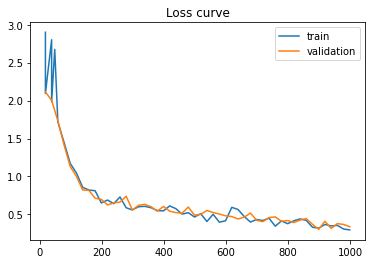

In [ ]:
import pandas as pd
metrics_df = pd.read_json(os.path.join(cfg.OUTPUT_DIR,'metrics.json'), orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")   
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "total_val_loss" in mdf.columns:
    mdf2 = mdf[~mdf["total_val_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["total_val_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")

plt.savefig('loss curve.jpg')


In [ ]:
metrics_df.to_csv('metrics.csv')
metrics_df[:2]

,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,iteration,loss_box_reg,loss_cls,loss_mask,loss_rpn_cls,loss_rpn_loc,lr,mask_rcnn/accuracy,mask_rcnn/false_negative,mask_rcnn/false_positive,roi_head/num_bg_samples,roi_head/num_fg_samples,rpn/num_neg_anchors,rpn/num_pos_anchors,time,total_loss,total_val_loss,val_loss_box_reg,val_loss_cls,val_loss_mask,val_loss_rpn_cls,val_loss_rpn_loc
0,0.047654,273.539181,0.289062,0.647917,0.00000,19,0.803896,1.375027,0.695067,0.016471,0.005970,0.000005,0.256099,0.824863,0.564746,49.0,15.0,251.0,5.0,8.823845,2.900403,NaN,NaN,NaN,NaN,NaN,NaN
1,0.050814,95.200256,0.484375,0.700893,0.03125,39,0.771791,1.315153,0.685640,0.018365,0.010359,0.000010,0.838802,0.000000,1.000000,51.5,12.5,250.0,6.0,8.654569,2.801749,NaN,NaN,NaN,NaN,NaN,NaN


# Add values to neptune ai run

In [ ]:
run['MAP'] = res
run['no of train images'] = len(os.listdir(train_images_dir))
run['no of val images'] = len(os.listdir(val_images_dir))
run['no of workers'] = cfg.DATALOADER.NUM_WORKERS
run['images per batch'] = cfg.SOLVER.IMS_PER_BATCH
run['learning rate'] = cfg.SOLVER.BASE_LR
run['no of iterations'] = cfg.SOLVER.MAX_ITER
run['batch size per image'] = cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE
run['no of classes'] = cfg.MODEL.ROI_HEADS.NUM_CLASSES
run['metrics'].upload('./metrics.csv')
run['loss curve'].upload('./loss curve.jpg')

In [ ]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.


All 1 operations synced, thanks for waiting!


# **Detect on Custom Images**

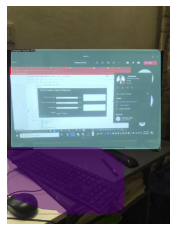

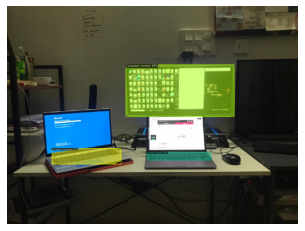

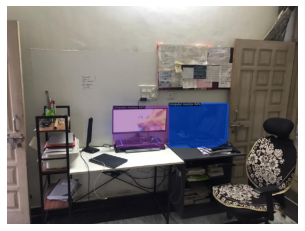

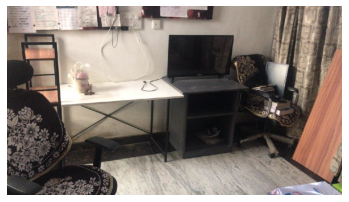

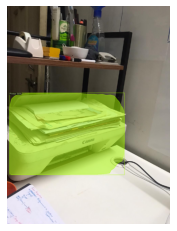

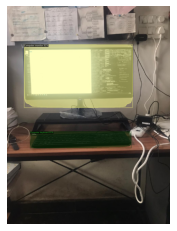

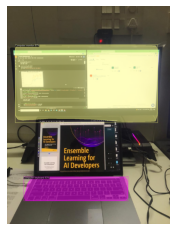

In [ ]:
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt

# cfg = get_cfg()
# #cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
# cfg.DATASETS.TRAIN = ("train",)
# cfg.DATASETS.TEST = ()
# cfg.DATALOADER.NUM_WORKERS = 2
# #cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR 0.00025 
# cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # only has one class (ballon)

# #Use the final weights generated after successful training for inference  
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
#Pass the validation dataset
cfg.DATASETS.TEST = ("val", )

predictor = DefaultPredictor(cfg)


base_path = '/content/drive/MyDrive/testing/test_images/pmk_personal_testimages/'
for i in os.listdir(base_path):
  if i[-3:] == 'jpg' or 'jpeg':
    img_path = base_path + i 
    im = cv2.imread(img_path)
    outputs = predictor(im)
    # print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Passing the predictions to CPU from the GPU
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
!python --version

Python 3.7.12
